**Lab2-DL: A3-MNIST-datasamling.ipynb** (ELMED219) | Prioritet: 3 (valgfri)

_Datainnsamling, inspeksjon og organisering av MNIST-datasettet_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A3-MNIST-datasamling.ipynb)

Sist oppdatert: 2025-12-04, A. Lundervold

Bruk `elmed219-2026` conda-miljøet eller Google Colab

---

## Innledning og motivasjon

### Hvorfor MNIST?

**MNIST** (Modified National Institute of Standards and Technology) er et klassisk datasett for bildegjenkjenning:

| Egenskap | Verdi |
|----------|-------|
| **Bilder** | 70 000 håndskrevne sifre (0-9) |
| **Størrelse** | 28×28 piksler, gråtone |
| **Oppgave** | Klassifisering (10 klasser) |
| **Bruksområde** | Benchmark for ML-algoritmer |

### Hvorfor lære datainnsamling?

I medisinsk AI jobber vi ofte med:
- **Bildefiler** (DICOM, PNG, JPEG) som må organiseres
- **Metadata** (pasient-ID, diagnose) som må kobles til bilder
- **Store datasett** som krever effektiv lagring

Denne notebooken lærer deg:
1. 📥 **Laste ned** data programmatisk
2. 🔍 **Inspisere** og forstå datastrukturen
3. 💾 **Lagre** data effektivt (komprimering!)
4. 📊 **Analysere** datasettet før modellering

In [22]:
# === Sjekk kjøremiljø ===
# Sjekker om vi kjører i Google Colab eller lokalt

try:
    import google.colab
    ER_COLAB = True
    print("✅ Kjører i Google Colab")
except ImportError:
    ER_COLAB = False
    print("💻 Kjører lokalt (ikke Colab)")

💻 Kjører lokalt (ikke Colab)


In [23]:
# === Importer nødvendige biblioteker ===

import numpy as np              # Numerisk beregning
import pandas as pd             # Tabelldata
import matplotlib.pyplot as plt # Visualisering
import os                       # Filhåndtering
import gzip                     # Komprimering
from pathlib import Path        # Stihåndtering

# PyTorch for datainnlasting
from torchvision import datasets
import torchvision.transforms as transforms

print("✅ Alle biblioteker lastet inn")

✅ Alle biblioteker lastet inn


---

## 1. Last ned MNIST-data

Vi laster MNIST som **tabelldata** (flate vektorer) – hvert bilde blir en rad med 784 kolonner (28×28 piksler).

In [24]:
def last_mnist_data(antall_bilder=None, tilfeldig_seed=42):
    """
    Laster MNIST-datasettet som tabelldata.
    
    Parametere:
    -----------
    antall_bilder : int, valgfri
        Antall bilder å laste. None = alle 70 000.
    tilfeldig_seed : int
        Seed for reproduserbarhet
        
    Returnerer:
    -----------
    X : array (n_bilder, 784)
        Pikseldata (normalisert 0-1)
    y : array (n_bilder,)
        Siffer-etiketter (0-9)
    """
    print("📥 Laster MNIST-data...")
    
    if ER_COLAB:
        # Google Colab: Bruk tensorflow_datasets
        import tensorflow_datasets as tfds
        datasett = tfds.load('mnist', split='train+test', as_supervised=True)
        X, y = [], []
        for bilde, etikett in datasett:
            X.append(bilde.numpy().reshape(784))
            y.append(etikett.numpy())
        X = np.array(X) / 255.0
        y = np.array(y)
    else:
        # Lokalt: Bruk PyTorch
        data_mappe = Path('./data')
        
        mnist_trening = datasets.MNIST(
            root=data_mappe, train=True, download=True,
            transform=transforms.ToTensor()
        )
        mnist_test = datasets.MNIST(
            root=data_mappe, train=False, download=True,
            transform=transforms.ToTensor()
        )
        
        # Konverter til numpy og normaliser
        X_trening = mnist_trening.data.numpy().reshape(60000, -1) / 255.0
        X_test = mnist_test.data.numpy().reshape(10000, -1) / 255.0
        y_trening = mnist_trening.targets.numpy()
        y_test = mnist_test.targets.numpy()
        
        # Kombiner trenings- og testdata
        X = np.concatenate([X_trening, X_test])
        y = np.concatenate([y_trening, y_test])
    
    totalt_tilgjengelig = len(X)
    print(f"   Totalt tilgjengelig: {totalt_tilgjengelig:,} bilder")
    
    # Ta et tilfeldig utvalg hvis ønsket
    if antall_bilder is not None:
        antall_bilder = min(antall_bilder, totalt_tilgjengelig)
        np.random.seed(tilfeldig_seed)
        indekser = np.random.choice(totalt_tilgjengelig, antall_bilder, replace=False)
        X = X[indekser]
        y = y[indekser]
        print(f"   Bruker utvalg: {antall_bilder:,} bilder")
    
    return X, y

In [25]:
# === Last inn et utvalg av MNIST ===

ANTALL_BILDER = 20000  # Juster opp til 70 000 ved behov

X, y = last_mnist_data(antall_bilder=ANTALL_BILDER)

print(f"\n📊 Datasett-info:")
print(f"   Form på X: {X.shape} (bilder × piksler)")
print(f"   Form på y: {y.shape} (etiketter)")
print(f"   Unike klasser: {np.unique(y)}")

📥 Laster MNIST-data...
   Totalt tilgjengelig: 70,000 bilder
   Bruker utvalg: 20,000 bilder

📊 Datasett-info:
   Form på X: (20000, 784) (bilder × piksler)
   Form på y: (20000,) (etiketter)
   Unike klasser: [0 1 2 3 4 5 6 7 8 9]


---

## 2. Visualiser dataene

La oss se på noen eksempler og gjennomsnittlige sifre.

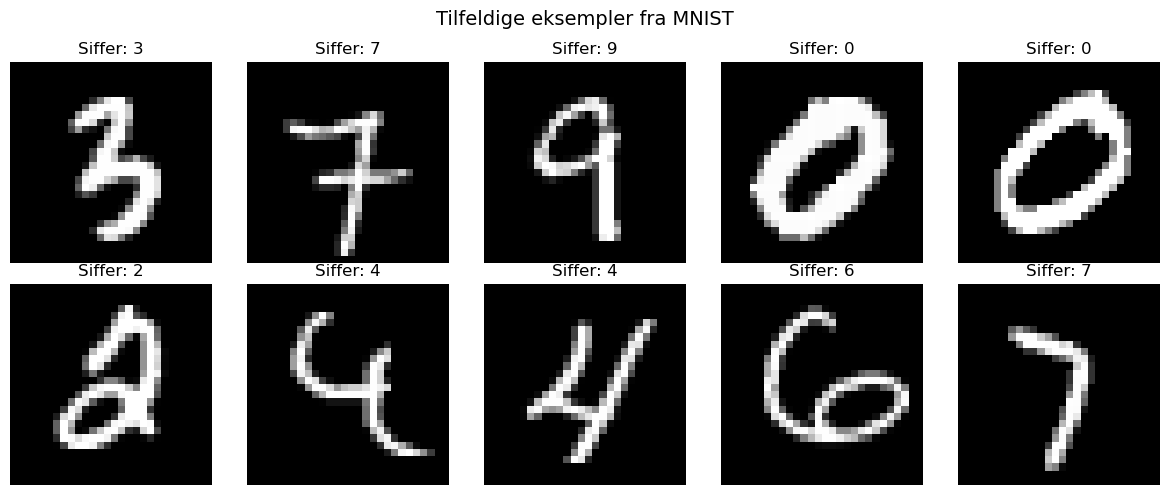

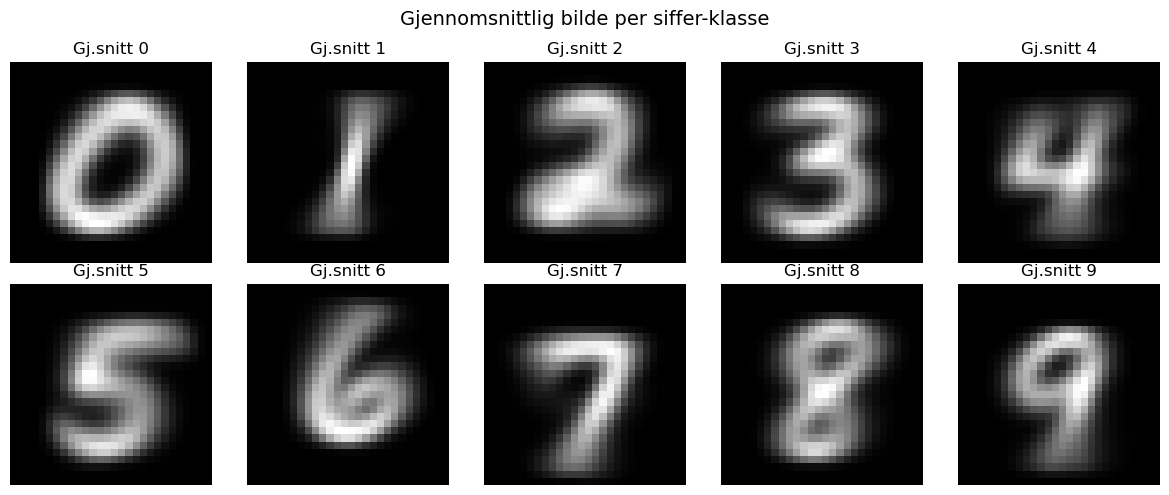

In [26]:
def vis_eksempler(X, y, antall=10):
    """Viser tilfeldige eksempler fra datasettet."""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    indekser = np.random.choice(len(X), antall, replace=False)
    
    for i, idx in enumerate(indekser):
        bilde = X[idx].reshape(28, 28)
        axes[i].imshow(bilde, cmap='gray')
        axes[i].set_title(f'Siffer: {y[idx]}', fontsize=12)
        axes[i].axis('off')
    
    plt.suptitle('Tilfeldige eksempler fra MNIST', fontsize=14)
    plt.tight_layout()
    plt.show()

def vis_gjennomsnitt_per_klasse(X, y):
    """Viser gjennomsnittlig bilde for hvert siffer."""
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for siffer in range(10):
        bilder_for_siffer = X[y == siffer]
        gjennomsnitt = bilder_for_siffer.mean(axis=0).reshape(28, 28)
        
        axes[siffer].imshow(gjennomsnitt, cmap='gray')
        axes[siffer].set_title(f'Gj.snitt {siffer}', fontsize=12)
        axes[siffer].axis('off')
    
    plt.suptitle('Gjennomsnittlig bilde per siffer-klasse', fontsize=14)
    plt.tight_layout()
    plt.show()

# Vis eksempler
vis_eksempler(X, y)
vis_gjennomsnitt_per_klasse(X, y)

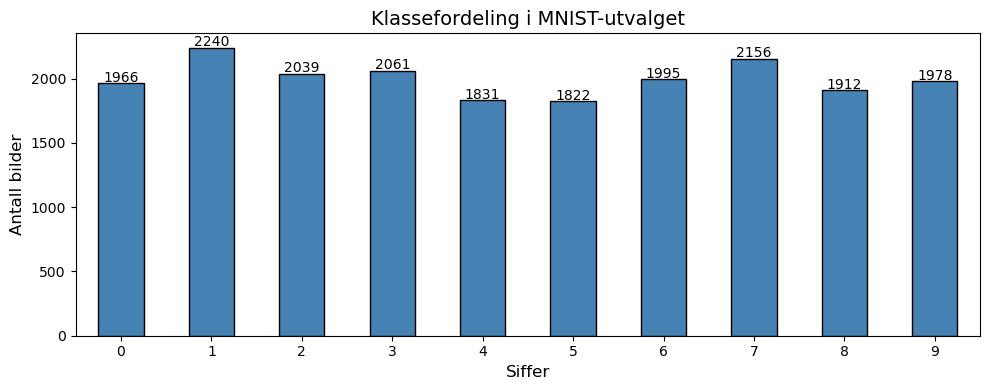


📊 Klassefordeling:
   Antall
0    1966
1    2240
2    2039
3    2061
4    1831
5    1822
6    1995
7    2156
8    1912
9    1978


In [27]:
# === Klassefordeling ===

klassefordeling = pd.Series(y).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 4))
klassefordeling.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Siffer', fontsize=12)
ax.set_ylabel('Antall bilder', fontsize=12)
ax.set_title('Klassefordeling i MNIST-utvalget', fontsize=14)
ax.set_xticklabels(range(10), rotation=0)

# Legg til tall over søylene
for i, v in enumerate(klassefordeling.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Klassefordeling:")
print(klassefordeling.to_frame('Antall'))

---

## 3. Effektiv datalagring

### Hvorfor komprimering er viktig

I medisinsk AI håndterer vi ofte:
- **Store bildefiler** (MR, CT, røntgen)
- **Mange pasienter** (tusenvis av filer)
- **Begrenset lagringsplass** (lokal disk, sky)

**Komprimering** kan redusere filstørrelsen betydelig uten å miste informasjon (lossless).

| Format | Beskrivelse | Typisk kompresjon |
|--------|-------------|-------------------|
| `.csv` | Ukomprimert tekst | 1× (baseline) |
| `.csv.gz` | Gzip-komprimert | 5-10× mindre |
| `.parquet` | Kolonnebasert binær | 10-20× mindre |

In [28]:
# === Lag DataFrame med pikseldata ===

# Kolonnenavn for hver piksel
piksel_kolonner = [f'piksel_{i}' for i in range(784)]

# Lag DataFrame
df = pd.DataFrame(X, columns=piksel_kolonner)
df['etikett'] = y

print(f"📊 DataFrame-info:")
print(f"   Form: {df.shape}")
print(f"   Kolonner: {len(piksel_kolonner)} piksler + 1 etikett")
print(f"   Minnebruk: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

df.head()

📊 DataFrame-info:
   Form: (20000, 785)
   Kolonner: 784 piksler + 1 etikett
   Minnebruk: 125.6 MB


,piksel_0,piksel_1,piksel_2,piksel_3,piksel_4,piksel_5,piksel_6,piksel_7,piksel_8,piksel_9,...,piksel_775,piksel_776,piksel_777,piksel_778,piksel_779,piksel_780,piksel_781,piksel_782,piksel_783,etikett
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [29]:
# === Lagre data: Sammenlign komprimert vs ukomprimert ===

# Lag mappe for data
data_mappe = Path('mnist_data')
data_mappe.mkdir(exist_ok=True)

# Filnavn
filnavn_base = f'mnist_{ANTALL_BILDER}bilder'
csv_fil = data_mappe / f'{filnavn_base}.csv'
gzip_fil = data_mappe / f'{filnavn_base}.csv.gz'

# 1. Lagre UKOMPRIMERT
print("💾 Lagrer ukomprimert CSV...")
df.to_csv(csv_fil, index=False)
ukomprimert_størrelse = csv_fil.stat().st_size

# 2. Lagre KOMPRIMERT (gzip)
print("📦 Lagrer komprimert CSV (gzip)...")
df.to_csv(gzip_fil, index=False, compression='gzip')
komprimert_størrelse = gzip_fil.stat().st_size

# 3. Beregn komprimeringsforhold
komprimering_faktor = ukomprimert_størrelse / komprimert_størrelse

print("\n" + "="*50)
print("📊 STØRRELSESSAMMENLIGNING")
print("="*50)
print(f"")
print(f"   Ukomprimert (.csv):     {ukomprimert_størrelse / 1e6:>8.2f} MB")
print(f"   Komprimert (.csv.gz):   {komprimert_størrelse / 1e6:>8.2f} MB")
print(f"")
print(f"   💡 Komprimering:        {komprimering_faktor:.1f}× mindre!")
print(f"   💡 Spart plass:         {(ukomprimert_størrelse - komprimert_størrelse) / 1e6:.2f} MB")
print("="*50)

💾 Lagrer ukomprimert CSV...
📦 Lagrer komprimert CSV (gzip)...

📊 STØRRELSESSAMMENLIGNING

   Ukomprimert (.csv):       106.12 MB
   Komprimert (.csv.gz):       5.95 MB

   💡 Komprimering:        17.8× mindre!
   💡 Spart plass:         100.16 MB


### Lese komprimert data

Pandas kan lese `.csv.gz`-filer direkte – dekomprimering skjer automatisk!

In [30]:
# === Les komprimert CSV direkte ===

import time

# Tid lesing av ukomprimert
start = time.time()
df_ukomprimert = pd.read_csv(csv_fil)
tid_ukomprimert = time.time() - start

# Tid lesing av komprimert
start = time.time()
df_komprimert = pd.read_csv(gzip_fil)  # Automatisk dekomprimering!
tid_komprimert = time.time() - start

print("⏱️ LESETID-SAMMENLIGNING")
print("="*40)
print(f"   Ukomprimert (.csv):     {tid_ukomprimert:.3f} s")
print(f"   Komprimert (.csv.gz):   {tid_komprimert:.3f} s")
print("="*40)

# Verifiser at dataene er identiske
er_identiske = df_ukomprimert.equals(df_komprimert)
print(f"\n✅ Data er identiske: {er_identiske}")

⏱️ LESETID-SAMMENLIGNING
   Ukomprimert (.csv):     0.397 s
   Komprimert (.csv.gz):   0.439 s

✅ Data er identiske: True


---

## 4. Sammenlign med bildefiler

Hva tar mest plass: **CSV-tabell** eller **PNG-bilder**?

In [31]:
# === Lagre som PNG-bilder og sammenlign ===

bilde_mappe = Path('mnist_data/bilder')
bilde_mappe.mkdir(parents=True, exist_ok=True)

# Lagre første 100 bilder som PNG (for å spare tid)
antall_png = min(100, len(X))
print(f"💾 Lagrer {antall_png} bilder som PNG...")

for i in range(antall_png):
    bilde = X[i].reshape(28, 28)
    filsti = bilde_mappe / f'siffer_{i:04d}.png'
    plt.imsave(filsti, bilde, cmap='gray')

# Beregn total PNG-størrelse
png_filer = list(bilde_mappe.glob('*.png'))
total_png_størrelse = sum(f.stat().st_size for f in png_filer)
gjennomsnitt_png = total_png_størrelse / len(png_filer)

# Estimer for hele datasettet
estimert_total_png = gjennomsnitt_png * ANTALL_BILDER

print("\n" + "="*55)
print("📊 LAGRINGSFORMAT-SAMMENLIGNING")
print("="*55)
print(f"")
print(f"   Format                  Størrelse    Per bilde")
print(f"   ─────────────────────────────────────────────────")
print(f"   PNG-bilder (estimert):  {estimert_total_png/1e6:>6.2f} MB   {gjennomsnitt_png:.0f} bytes")
print(f"   CSV (ukomprimert):      {ukomprimert_størrelse/1e6:>6.2f} MB   {ukomprimert_størrelse/ANTALL_BILDER:.0f} bytes")
print(f"   CSV.GZ (komprimert):    {komprimert_størrelse/1e6:>6.2f} MB   {komprimert_størrelse/ANTALL_BILDER:.0f} bytes")
print(f"")
print(f"   💡 Beste valg for MNIST: CSV.GZ (komprimert tabell)")
print("="*55)

💾 Lagrer 100 bilder som PNG...

📊 LAGRINGSFORMAT-SAMMENLIGNING

   Format                  Størrelse    Per bilde
   ─────────────────────────────────────────────────
   PNG-bilder (estimert):   12.61 MB   631 bytes
   CSV (ukomprimert):      106.12 MB   5306 bytes
   CSV.GZ (komprimert):      5.95 MB   298 bytes

   💡 Beste valg for MNIST: CSV.GZ (komprimert tabell)


---

## 5. Opprydding og anbefaling

### Anbefalt arbeidsflyt

```
1. Last data (PyTorch/sklearn)  →  2. Forbered DataFrame  →  3. Lagre som .csv.gz
```

**For ELMED219:** Vi bruker den komprimerte `.csv.gz`-filen i de neste notebookene.

In [32]:
# === Opprydding: Slett ukomprimert fil og PNG-bilder ===

import shutil

# Slett ukomprimert CSV (beholder kun .csv.gz)
if csv_fil.exists():
    csv_fil.unlink()
    print(f"🗑️ Slettet: {csv_fil}")

# Slett PNG-bildemappe
if bilde_mappe.exists():
    shutil.rmtree(bilde_mappe)
    print(f"🗑️ Slettet: {bilde_mappe}/")

print(f"\n✅ Beholder kun: {gzip_fil}")
print(f"   Størrelse: {gzip_fil.stat().st_size / 1e6:.2f} MB")

🗑️ Slettet: mnist_data/mnist_20000bilder.csv
🗑️ Slettet: mnist_data/bilder/

✅ Beholder kun: mnist_data/mnist_20000bilder.csv.gz
   Størrelse: 5.95 MB


---

## Oppsummering

| Tema | Hva vi lærte |
|------|-------------|
| **Datainnlasting** | Bruk PyTorch (`torchvision.datasets`) for å laste MNIST |
| **Visualisering** | Inspiser data visuelt før modellering |
| **Komprimering** | `.csv.gz` gir ~5-10× plassbesparelse |
| **Valg av format** | Komprimert CSV er best for tabelldata |

### Neste steg

Gå videre til:
- **A4-MNIST-Random-Forest**: Klassifisering med tradisjonell ML
- **A5-MNIST-MLP**: Klassifisering med nevralt nettverk
- **A6-MNIST-CNN**: Klassifisering med CNN

---

## 🎯 Oppgaver

### Oppgave 1: Endre antall bilder
Kjør notebooken med `ANTALL_BILDER = 10000`. Hvordan endrer komprimeringsforholdet seg?

<details>
<summary>💡 Vis svar</summary>

Komprimeringsforholdet forblir omtrent det samme (~5-10×), men du sparer mer absolutt plass med flere bilder.

</details>

### Oppgave 2: Utforsk Parquet-format
Pandas støtter også `.parquet`-format. Prøv:
```python
df.to_parquet('mnist.parquet')
```
Sammenlign størrelsen med `.csv.gz`.

<details>
<summary>💡 Vis svar</summary>

```python
# Lagre som Parquet
parquet_fil = data_mappe / 'mnist.parquet'
df.to_parquet(parquet_fil)
print(f"Parquet: {parquet_fil.stat().st_size / 1e6:.2f} MB")
# Parquet er ofte enda mer kompakt enn gzip-CSV!
```

</details>